**1. Instalación y Carga de Librerías**

En este bloque se instalan y cargan las librerías necesarias para la exploración inicial del dataset.

In [ ]:
# Instalación de librerías necesarias (si no están instaladas en Colab)
!pip install nltk scikit-learn spacy gensim wordcloud
!pip install adjustText
!python -m spacy download en_core_web_sm
!pip install stop-words

# Importación de librerías
import pandas as pd
import numpy as np
import spacy
import os
import re
import gzip
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk import ngrams
from nltk.probability import FreqDist
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from adjustText import adjust_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 90.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


**2. Cargar el dataset preprocesado de la Etapa 1**

En esta parte, cargo el dataset limpio y explorado desde la Etapa 1.

In [ ]:
# Cargar el dataset preprocesado desde la Etapa 1
df = pd.read_csv("preprocessed_reviews.csv")

# Mostrar algunas filas para revisar los datos
display(df.head())

# Verificar si hay valores nulos antes del preprocesamiento de texto
print("Valores nulos en el dataset:")
print(df.isnull().sum())


,reviewText,overall
0,My daughter wanted this book and the price on ...,5.0
1,I bought this zoku quick pop for my daughterr ...,5.0
2,There is no shortage of pop recipes available ...,4.0
3,This book is a must have if you get a Zoku (wh...,5.0
4,This cookbook is great. I have really enjoyed...,4.0


Valores nulos en el dataset:
reviewText    0
overall       0
dtype: int64


# **Preprocesado de Texto**

**1. Preprocesado incluido en una función de Python**

Ajusto el preprocesamiento tras revisar previamente los N-grams:

Aparecen términos como "t" y "s", que probablemente sean errores de tokenización o restos de contracciones ("it's", "that's", etc.).

Presencia de palabras poco informativas → "one", "make", "can", aunque pueden ser útiles, son muy genéricas y podrían considerarse stopwords contextuales.

Tengo la sensación de que podría añadir medio dataset a la lista de stopwords, pero no me quedo seguro de si eso ayudaría o si terminaría eliminando palabras relevantes para el análisis. 🤔

In [ ]:
# Cargar el dataset preprocesado desde la Etapa 1
df = pd.read_csv("preprocessed_reviews.csv")

# Verificar si la columna 'clean_review' ya existe
if 'clean_review' not in df.columns:
    print("Advertencia: La columna 'clean_review' no se encuentra en el dataset.")
    print("Se procederá a realizar el preprocesamiento de texto.\n")

    # Cargar modelo SpaCy
    nlp = spacy.load("en_core_web_sm")

    # Obtener stopwords de spaCy
    stopwords = nlp.Defaults.stop_words

    # Lista de stopwords personalizadas después de la lematización
    custom_stopwords = set([
        "use", "make", "work", "buy", "get", "put", "take", "go", "want", "need", "look", "see",
        "thing", "one", "time", "way", "set", "back", "find", "come", "try", "keep", "still",
        "really", "lot", "like", "well", "will", "bit", "quite", "nice"
    ])

    # Unir stopwords de spaCy con las personalizadas
    stopwords.update(custom_stopwords)

    def limpiar_texto(doc):
        """
        Función mejorada para limpiar texto con SpaCy:
        - Convierte a minúsculas
        - Elimina caracteres especiales y espacios extra
        - Lematiza y elimina stopwords antes y después de la lematización
        - Conserva solo palabras alfabéticas
        - Filtra palabras demasiado cortas (1 o 2 caracteres)
        """
        tokens_limpiados = [
            token.lemma_.lower() for token in doc
            if token.text.lower() not in stopwords  # Filtra stopwords en su forma base
            and token.lemma_ not in stopwords  # Filtra stopwords en su forma lematizada
            and token.is_alpha  # Solo palabras alfabéticas
            and len(token.lemma_) > 2  # Filtrar palabras muy cortas
        ]
        return " ".join(tokens_limpiados)

    # Aplicar preprocesamiento con `nlp.pipe()` en batch
    df["clean_review"] = [
        limpiar_texto(doc) for doc in nlp.pipe(df["reviewText"].dropna(), batch_size=50)
    ]

    # Guardar el dataset preprocesado de la Etapa 2 con un nuevo nombre
    df.to_csv("preprocessed_reviews2.csv", index=False)
    print("Dataset preprocesado guardado como 'preprocessed_reviews2.csv'.")

# Mostrar primeras filas con reviews preprocesadas
display(df[["reviewText", "clean_review"]].head())

# Verificar palabras más frecuentes después del preprocesamiento
word_counts = Counter(" ".join(df["clean_review"]).split())

print("Top 10 palabras más frecuentes después del preprocesamiento:")
print(word_counts.most_common(10))



Advertencia: La columna 'clean_review' no se encuentra en el dataset.
Se procederá a realizar el preprocesamiento de texto.



/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Dataset preprocesado guardado como 'preprocessed_reviews2.csv'.


,reviewText,clean_review
0,My daughter wanted this book and the price on ...,daughter book price amazon good recipe day rec...
1,I bought this zoku quick pop for my daughterr ...,zoku quick pop daughterr zoku quick maker love...
2,There is no shortage of pop recipes available ...,shortage pop recipe available free web purchas...
3,This book is a must have if you get a Zoku (wh...,book zoku highly recommend large variety recip...
4,This cookbook is great. I have really enjoyed...,cookbook great enjoy review recipe sure diffic...


Top 10 palabras más frecuentes después del preprocesamiento:
[('good', 4135), ('great', 3332), ('easy', 3288), ('handle', 2885), ('cup', 2762), ('knife', 2324), ('year', 2143), ('clean', 2119), ('product', 2089), ('love', 2074)]


# **Análisis sobre el Texto Preprocesado (Visualización)**

**1. N-grams Más Frecuentes**

Calcula la frecuencia de unigramas, bigramas y trigramas

Muestra los N-grams más comunes en gráficos de barras.




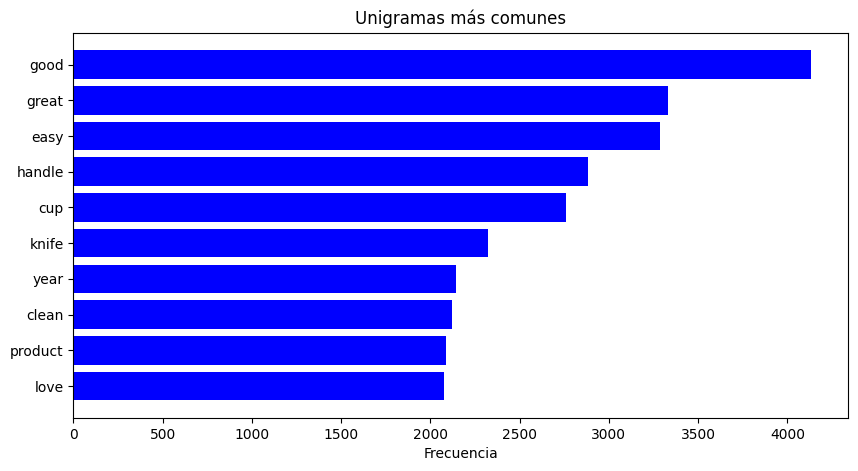

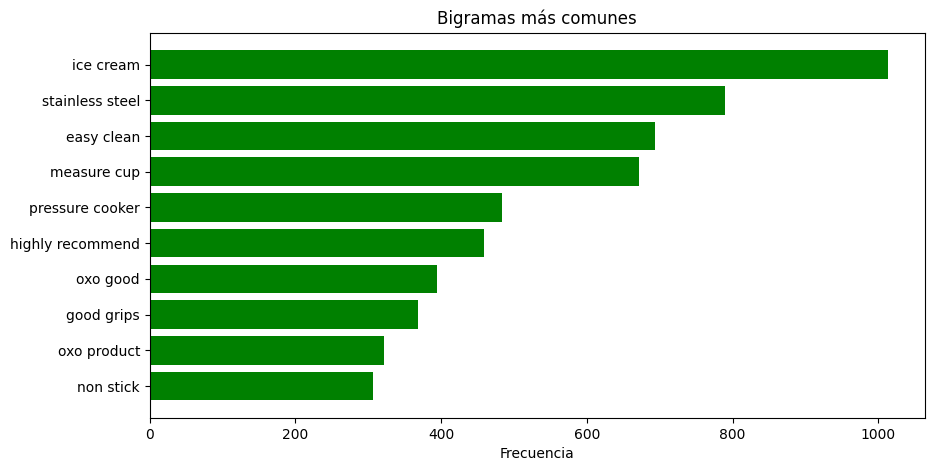

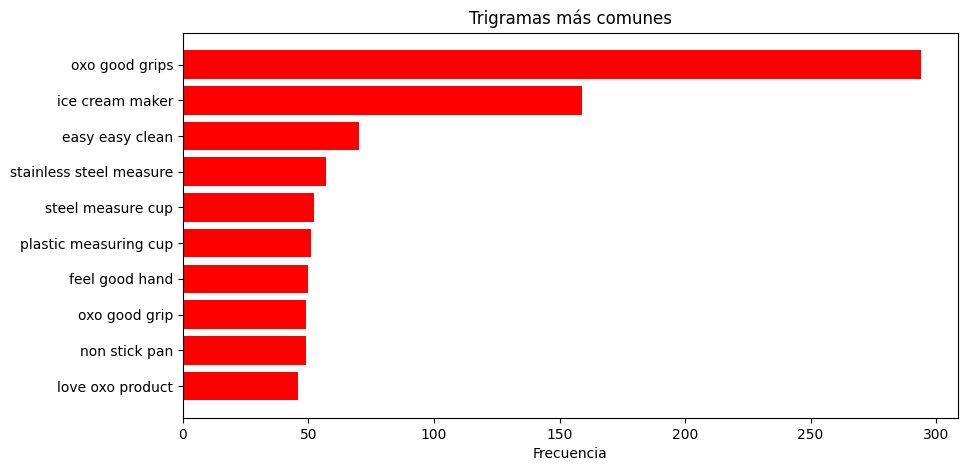

In [ ]:
# Obtener todas las palabras tokenizadas del dataset preprocesado
all_words = " ".join(df["clean_review"].dropna()).split()

# Generar unigramas, bigramas y trigramas
unigrams = list(ngrams(all_words, 1))
bigrams = list(ngrams(all_words, 2))
trigrams = list(ngrams(all_words, 3))

# Calcular la frecuencia de los N-gramas
freq_unigrams = FreqDist(unigrams)
freq_bigrams = FreqDist(bigrams)
freq_trigrams = FreqDist(trigrams)

# Función para graficar los N-grams más comunes
def plot_ngrams(ngrams_freq, title, color="blue"):
    labels, values = zip(*ngrams_freq)
    labels = [" ".join(ngram) for ngram in labels]

    plt.figure(figsize=(10, 5))
    plt.barh(labels[::-1], values[::-1], color=color)
    plt.xlabel("Frecuencia")
    plt.title(title)
    plt.show()

# Mostrar los 10 N-gramas más frecuentes
plot_ngrams(freq_unigrams.most_common(10), "Unigramas más comunes", "blue")
plot_ngrams(freq_bigrams.most_common(10), "Bigramas más comunes", "green")
plot_ngrams(freq_trigrams.most_common(10), "Trigramas más comunes", "red")

Interpretación de los resultados:

Unigramas más comunes:

Las palabras más frecuentes en las reseñas son "good", "great", "easy", "handle", "cup", "knife", "year", "clean", "product" y "love".
Se observa una fuerte presencia de términos relacionados con la calidad y facilidad de uso de los productos:
"good", "great", "easy" → Positivas en general, reflejan satisfacción del usuario.
"clean" → Indica que la facilidad de limpieza es un factor importante en las reseñas.
"handle", "cup", "knife" → Palabras que hacen referencia a utensilios de cocina.
"love" → Muestra una alta cantidad de reseñas positivas y entusiasmo por los productos.
"year" → Puede estar relacionado con la durabilidad o con el tiempo que llevan usando el producto.
Bigramas más comunes:

Los bigramas destacan combinaciones relevantes en la experiencia del usuario:
"ice cream" → Sugiere una alta cantidad de reseñas sobre productos relacionados con helados.
"stainless steel" → Indica que los materiales de los productos son un aspecto importante para los usuarios.
"easy clean" → Reafirma que la facilidad de limpieza es un punto clave en la evaluación de los productos.
"measure cup" → Relevante en productos de cocina, especialmente aquellos relacionados con medición.
"oxo good" y "oxo product" → Muestra que la marca OXO tiene una fuerte presencia en las reseñas.
"highly recommend" → Señal de que muchas reseñas incluyen recomendaciones.

Trigramas más comunes:
Aquí se observa una combinación de términos de calidad y marcas específicas:
"oxo good grips" → La marca OXO y su línea "Good Grips" tienen una presencia destacada en los comentarios.
"ice cream maker" → Reafirma que los productos para hacer helado son populares entre los usuarios.
"easy easy clean" → Posible indicio de que la facilidad de limpieza es un aspecto tan relevante que se repite en la redacción.
"steel measure cup" y "plastic measuring cup" → Diferenciación entre materiales en utensilios de medición.
"feel good hand" → Posiblemente relacionado con la ergonomía y comodidad en el uso de ciertos productos.
"non stick pan" → Destaca la importancia de los recubrimientos antiadherentes en las reseñas.
"love oxo product" → Refleja una alta apreciación por la marca OXO.

Conclusiones:
Factores clave para los usuarios: La facilidad de uso, calidad de los materiales y facilidad de limpieza son aspectos recurrentes en las reseñas.
Marcas destacadas: OXO aparece con frecuencia, lo que indica una alta popularidad entre los usuarios.
Productos más mencionados: Heladeras, utensilios de medición, sartenes antiadherentes y productos de acero inoxidable son los más comentados.
Positividad general: La presencia de palabras como "love", "good", "great" sugiere una tendencia positiva en las opiniones de los clientes.

**2. Generación de Nube de Palabras**

Crea una nube de palabras para visualizar los términos más frecuentes en las reseñas.

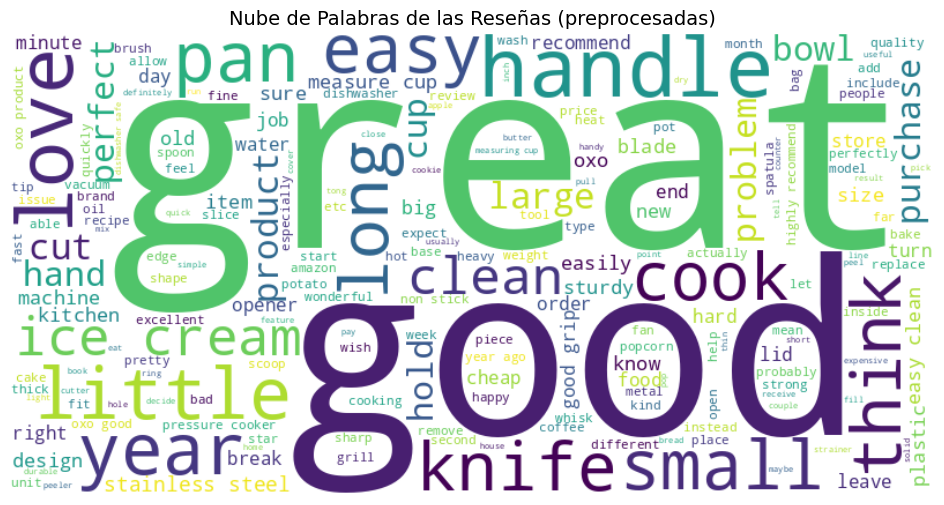

In [ ]:
# Concatenar todas las reseñas preprocesadas en un solo texto
all_text_clean = " ".join(df["clean_review"].dropna())

# Generar la nube de palabras con configuración personalizada
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="viridis",
    max_words=200  # Limitar a 200 palabras más frecuentes
).generate(all_text_clean)

# Mostrar la nube de palabras
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Ocultar ejes
plt.title("Nube de Palabras de las Reseñas (preprocesadas)", fontsize=14)
plt.show()


La nube de palabras muestra los términos más frecuentes en las reseñas de los productos de cocina.

Satisfacción general: La alta frecuencia de palabras como "good", "great", "easy" sugiere que los clientes tienen una percepción mayormente positiva de los productos.

Factores clave en la compra: La facilidad de uso, diseño, materiales y durabilidad son elementos fundamentales para los consumidores.

Productos destacados: Utensilios de cocina como cuchillos, tazas de medición y abridores son ampliamente mencionados en los comentarios.

Importancia del material: Se observan menciones frecuentes a materiales como "stainless steel" y "plastic", lo que indica que los compradores valoran las diferencias entre ellos.

Marcas y categorías populares: La mención de términos como "oxo" y "ice cream" sugiere que ciertos productos y marcas tienen una gran relevancia en las opiniones de los usuarios.

Este análisis proporciona información valiosa sobre qué aspectos son más importantes para los consumidores al evaluar productos de cocina, lo que puede ayudar a mejorar estrategias de marketing y desarrollo de productos.

**3. Visualización en 2D de Word Embeddings**

En este bloque se entrena un modelo Word2Vec con las reseñas preprocesadas. Luego, se seleccionan 5 palabras clave y se obtienen sus 10 palabras más similares. Finalmente, se aplica PCA para reducir la dimensionalidad y visualizar las relaciones entre los términos en un espacio bidimensional.

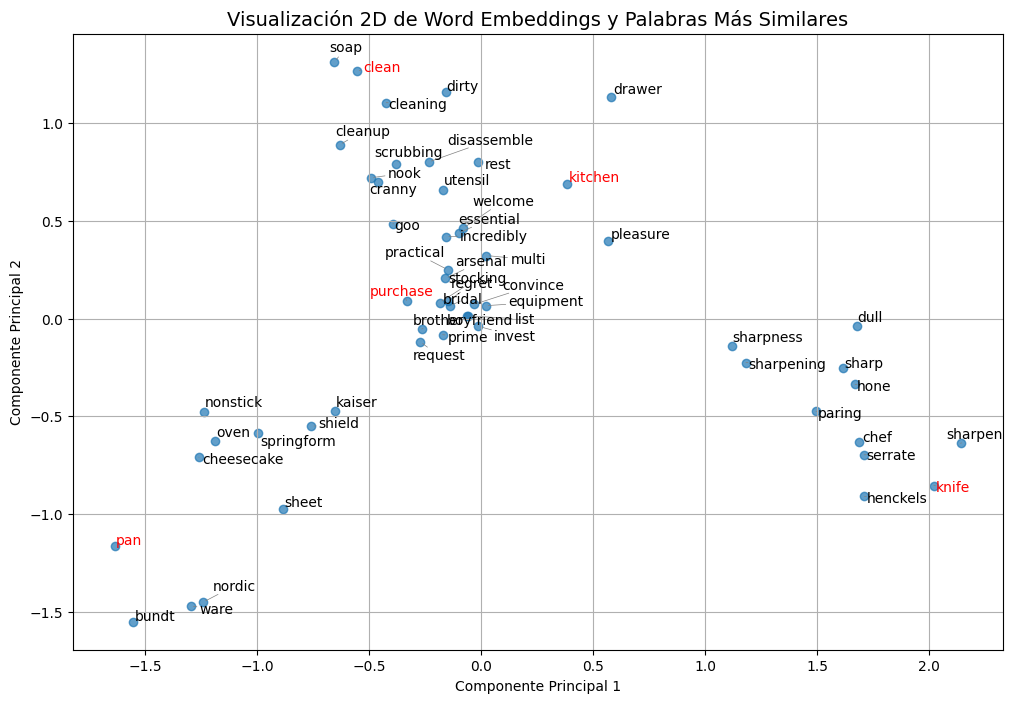

In [ ]:
# Entrenar el modelo Word2Vec con los textos preprocesados
sentences = [text.split() for text in df["clean_review"].dropna()]  # Convertir cada review en lista de palabras
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, sg=1, workers=4)

# Guardar el modelo entrenado para usarlo después
w2v_model.save("word2vec_model.bin")

# Seleccionar palabras clave para visualizar
words_to_visualize = ["kitchen", "knife", "pan", "clean", "purchase"]

# Obtener las 10 palabras más similares para cada una
word_labels = []
word_vectors = []
word_colors = []  # Lista para almacenar los colores

for word in words_to_visualize:
    if word in w2v_model.wv:
        word_labels.append(word)  # Añadir palabra clave
        word_vectors.append(w2v_model.wv[word])  # Obtener su vector
        word_colors.append("red")  # Rojo para palabras clave

        for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
            word_labels.append(similar_word)
            word_vectors.append(w2v_model.wv[similar_word])
            word_colors.append("black")  # Negro para palabras similares

# Convertir lista de vectores a numpy array
word_vectors = np.array(word_vectors)

# Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)

# Graficar las palabras en 2D
plt.figure(figsize=(12, 8))
plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1], alpha=0.7)

# Añadir etiquetas con `adjustText`
texts = []
for i, word in enumerate(word_labels):
    texts.append(plt.text(
        word_vectors_pca[i, 0], word_vectors_pca[i, 1], word,
        fontsize=10, color=word_colors[i]  # Color según tipo de palabra
    ))

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))  # Evita superposiciones

# Configuración del gráfico
plt.title("Visualización 2D de Word Embeddings y Palabras Más Similares", fontsize=14)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid()
plt.show()

Resultado:

El modelo ha identificado las palabras más similares a "kitchen", "knife", "clean", "pan" y "purchase", reflejando aspectos clave en las reseñas de productos de cocina.

"kitchen" se agrupa con términos como "utensil", "essential", "equipment" y "practical", lo que indica que los usuarios mencionan la cocina en relación con utensilios y herramientas indispensables.

"knife" se asocia con "sharp", "sharpening", "paring" y "chef", lo que resalta la importancia del filo y las marcas específicas en las opiniones.

"clean" aparece junto a "cleaning", "scrubbing", "soap" y "dirty", lo que sugiere que la facilidad de limpieza es un factor relevante en la experiencia del usuario.

"pan" está cerca de "nonstick", "oven", "cheesecake" y "springform", lo que indica que los usuarios valoran características antiadherentes y su aplicación en cocina y repostería.

"purchase" se vincula con "request", "invest", "prime" y "list", lo que refleja menciones sobre el proceso de compra y la toma de decisiones en Amazon u otras plataformas.

El modelo Word2Vec ha capturado correctamente relaciones semánticas en las reseñas, organizando las palabras según su contexto de uso. Esto lo hace útil para análisis como recomendaciones de productos o identificación de tendencias en la satisfacción del cliente.






